In [64]:
import os, glob
import numpy as np
import pandas as pd
from tqdm import tqdm

from astropy.table import Table, Column
from scipy.interpolate import interp1d

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.models import Label
output_notebook()

%matplotlib inline
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter


Loading BokehJS ...

In [151]:
def make_df(all_files, threshold=0.5):
    df= Table()
    mean_arr = []
    
    for i, val in enumerate(all_files):
        r = Table.read(val, format="csv")

        df.add_column(Column(np.round(r['pred'].data, 3),
                             name='s'+(val.split('_s')[-1]).split('_')[0]))

        mean_arr.append(np.round(r['pred'].data, 3))

    df.add_column(Column(np.nanmean(mean_arr, axis=0), name='pred'))
    
    df.add_column(Column(r['gt'].data, name='gt'), index=0)
    df.add_column(Column(r['tpeak'].data, name='peak'), index=0)
    df.add_column(Column(r['# tic'].data, name='tic'), index=0)
    
    pred_round = np.zeros(len(df))
    pred_round[df['pred'] >= threshold] = 1
    pred_round[df['pred'] < threshold]  = 0
    
    df.add_column(Column(pred_round, name='pred_round'), index=0)

    return df

In [152]:
def calc_metrics(df, threshold=0.5):
    """
    Calculates metrics for each model as well as the ensemble
    of models.
    """
    ap, ac = [], []
    rs, ps = [], []
    for i, val in enumerate(df.columns[4:]):
    
        # CALCULATES AVERAGE PRECISION SCORE
        ap.append(np.round(average_precision_score(df['gt'].data, 
                                                   df[val].data, average=None), 4))
        # ROUNDED BASED ON THRESHOLD
        arr = np.copy(df[val].data)
        arr[arr >= threshold] = 1.0
        arr[arr < threshold] = 0.0
        
        # CALCULATES ACCURACY
        ac.append(np.round(np.sum(arr == df['gt'].data) / len(df), 4))
        
        
    pred_round = np.zeros(len(df))
    pred_round[df['pred'] >= threshold] = 1
    pred_round[df['pred'] < threshold]  = 0
    
    # CALCULATES RECALL SCORE
    rs = np.round(recall_score(df['gt'], pred_round), 4)
        
    # CALCULATES PRECISION SCORE
    ps = np.round(precision_score(df['gt'], pred_round), 4)

    # LAST INDEX IS ENSEMBLED VALUE
    return ap, ac, rs, ps

In [153]:
### GET DATA FROM ENSEMBLE OF VAL SET
DATADIR = '/Users/arcticfox/Documents/flares/results/test/'
files = np.sort(glob.glob(os.path.join(DATADIR,"*i350*predval*.txt")))
files = np.sort(glob.glob(os.path.join(DATADIR, "predval*i0350*_b0.73.txt")))


DF = make_df(files)

ap, acc, recall, precision = calc_metrics(DF)

precision



0.9867

In [155]:
### PRINT RECALL AND PRECISION VALUES
#print(round(recall_score(DF['gt'], DF['pred_round']), 3), 
#      round(precision_score(DF['gt'], DF['pred_round']), 3))

### MAKE CONFUSON MATRIX
print(confusion_matrix(DF["gt"].data, DF["pred_round"].data))

# """
# [TN, FP]
# [FN, TP]
# """


[[1753    7]
 [  29  518]]


In [156]:
### INDEX CONFUSION MATRIX
ind_tn = np.where( (DF['pred_round'] == 0) & (DF['gt'] == 0) )
ind_fn = np.where( (DF['pred_round'] == 0) & (DF['gt'] == 1) )
ind_tp = np.where( (DF['pred_round'] == 1) & (DF['gt'] == 1) )
ind_fp = np.where( (DF['pred_round'] == 1) & (DF['gt'] == 0) )

In [168]:
FLARE_CATALOG = Table.read('/Users/arcticfox/Documents/flares/catalog_per_flare_final.csv',
                           format='ascii')

FC = FLARE_CATALOG.to_pandas()
for i, val in enumerate(ind_fp[0]):
    
    print(val, DF["peak"][val], DF["peak"][val] + 2457000, 
          DF["tic"][val], DF["pred"][val])
    
    # SEE IF VERY CLOSE TO KNOWN FLARE (REASON FOR FP)
    peak = DF["peak"][val] + 2457000.0
    fcc = FC.iloc[(FC['tpeak'] - peak).abs().argsort()[:1]]
    if (np.abs(fcc['tpeak'].data - peak) < 0.1) & (fcc['tic_id'].data[0] == DF["tic"][val]):
        print(i, val, fcc['tic_id'].data, fcc['tpeak'].data)
        
    lc = x_val[val]
    p1 = figure(width=750, height=300)
    p1.scatter(np.arange(len(lc)), lc)
    show(p1)

    if i > 20:
        break


281 1346.9965272309 2458346.996527231 180412528 0.9741666666666666


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Series.data is deprecated and will be removed in a future version
  del sys.path[0]


NameError: name 'x_val' is not defined

In [48]:
files = glob.glob("../lc/real/" + str(141334293).zfill(9) + "*.npy")
files


['../lc/real/141334293_sector02.npy', '../lc/real/141334293_sector01.npy']

In [50]:
data = np.load(files[1], allow_pickle=True)
time, flux, flux_err = data[0], data[1], data[2]
            
p1 = figure(width=750, height=300)
p1.scatter(time, flux)
show(p1)

In [38]:
ind = np.where( (TICS == 161174284) )

data = DATA[ind[0][-4]]

p1 = figure(width=750, height=300)
p1.scatter(np.arange(len(data)), data)
show(p1)

PEAKS[ind[0][-4]]

1325.5418370232835

In [158]:
def plot_lc(data, ind, ax, color, shift=0):
    
    ax.set_xlim([0, 200])
    ax.set_ylim([-2, +2])
    ax.axvline(100, linestyle='dotted', color='gray', linewidth=0.5)
    ax.set_yticks([])
    ax.set_xticks([])
 
    lc = np.copy(data[ind])
    lc -= np.median(lc)
    lc /= np.abs(np.max(lc, axis=0))
    lc += shift
    
    ax.plot(lc, color=color, linewidth=2.5)
    
    return ax

NameError: name 'x_val' is not defined

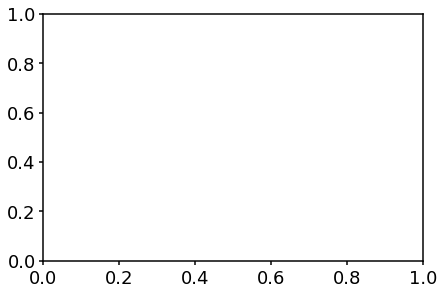

In [159]:
### SETUP PLOT
plt.close('all')
fig = plt.figure(figsize=(15, 10))
mpl.rc('xtick.major', size=4, pad=5, width=1.5)
mpl.rc('ytick.major', size=4, pad=3, width=1.5)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('axes', linewidth=1.5)
mpl.rc('lines', markersize=2)

pal = sns.color_palette("Set2", 6)
palhex = pal.as_hex()

### TRUE NEGATIVES (3, 6, 9, 17, 18, 410, 451)
ax_tn = fig.add_subplot(221)
ax_tn = plot_lc(x_val, ind_tn[0][410], ax_tn, palhex[2], shift=1)
ax_tn = plot_lc(x_val, ind_tn[0][9], ax_tn, palhex[5], shift=-.1)
ax_tn = plot_lc(x_val, ind_tn[0][17], ax_tn, palhex[1], shift=-0.8)
ax_tn.set_title('True Negatives: ' + str(len(ind_tn[0])) + ' (' + str(round(100 * len(ind_tn[0]) / len(y_val), 1)) + '%)', size=22)
ax_tn.set_facecolor('lightgray')

### FALSE POSITIVES (0, 1, 5, 8)
### 4 could be a real flare that was missed
ax_fp = fig.add_subplot(222)
ax_fp = plot_lc(x_val, ind_fp[0][6], ax_fp, palhex[5], shift=-1.5)
ax_fp = plot_lc(x_val, ind_fp[0][4], ax_fp, palhex[2], shift=+0.9)
ax_fp = plot_lc(x_val, ind_fp[0][1], ax_fp, palhex[1], shift=-0.1)
ax_fp.set_title('False Positives: ' + str(len(ind_fp[0])) + ' (' + str(round(100 * len(ind_fp[0]) / len(y_val), 1)) + '%)', size=22)

### FALSE NEGATIVES (2, 4, 5, 8, 9, 10, 13, 19)
ax_fn = fig.add_subplot(223)
ax_fn = plot_lc(x_val, ind_fn[0][2], ax_fn, palhex[5])
ax_fn = plot_lc(x_val, ind_fn[0][4], ax_fn, palhex[2], shift=+.7)
ax_fn = plot_lc(x_val, ind_fn[0][9], ax_fn, palhex[1], shift=-1.3)
ax_fn.set_title('False Negatives: ' + str(len(ind_fn[0])) + ' (' + str(round(100 * len(ind_fn[0]) / len(y_val), 1)) + '%)', size=22)

### TRUE POSITIVES
ax_tp = fig.add_subplot(224)
ax_tp = plot_lc(x_val, ind_tp[0][2], ax_tp, palhex[5], shift=-0.5)
ax_tp = plot_lc(x_val, ind_tp[0][10], ax_tp, palhex[2], shift=+0.8)
ax_tp = plot_lc(x_val, ind_tp[0][40], ax_tp, palhex[1], shift=-1.7)
ax_tp.set_title('True Positives: ' + str(len(ind_tp[0])) + ' (' + str(round(100 * len(ind_tp[0]) / len(y_val), 1)) + '%)', size=22)
ax_tp.set_facecolor('lightgray')

#plt.savefig('../results/confusionmatrix.pdf', bbox_inches='tight', dpi=200, rastersized=True)